In [1]:
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
import re
import fastai

print(torch.__version__)
print(transformers.__version__)
print( fastai.__version__)

1.8.0
4.20.1
2.7.7


In [2]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
  bos_token='</s>', eos_token='</s>', unk_token='<unk>',
  pad_token='<pad>', mask_token='<mask>') 
model = AutoModelWithLMHead.from_pretrained("skt/kogpt2-base-v2")
text = """ 옛날 옛날 어느 마을에 흥부와 놀부 형제가 """
input_ids = tokenizer.encode(text)
gen_ids = model.generate(torch.tensor([input_ids]),
                           max_length=128,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True
                        )
generated = tokenizer.decode(gen_ids[0,:].tolist())
print(generated)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
c:\ProgramData\Anaconda3\envs\readvice\lib\site-packages\transformers\models\auto\modeling_auto.py:969: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


옛날 옛날 어느 마을에 흥부와 놀부 형제가 왁자지껄 떠들어대며 "우리 집엔 왜 이렇게 많은 사람들이 모여 사는 거야?" 하고 묻는다.
그런데 그 마을 사람들은 모두 다들 자기네 동네에 살고 있는 사람들이라고 한다.
이렇게 해서 우리 마을은 '흥부가 살던 곳'이라는 뜻의 '고향'이 되었다.
그리고 이 고향은 바로 지금의 서울 종로구 숭인동이다.
숭인동은 원래 종로에서 가장 오래된 주택가였다.
1970년대까지만 해도 이곳은 재개발로 인해 헐리고 빈집이 많아졌다.
하지만 1980년대 들어 다시 활기를 되찾기 시작했다.
당시만 하더라도 이곳에는 낡은 건물들이 많이 남아 있었다.
그러나 1990년대 들어서부터는 예전의


In [27]:
import re

with open('./book_report_data.txt', 'r', encoding='utf-8') as f:
    data = f.read()
data=" ".join(data.split())
# print(len(data))
data = data.replace('\n|\t', ' ')
print(len(data))
# new_sent = data.replace(" ", '') # 띄어쓰기가 없는 문장 임의로 만들기
# # print(len(new_sent))
# spacing = Spacing()
# kospacing_sent = spacing(new_sent) 
# print(len(kospacing_sent))
data = re.sub('[-=+,#/\:^$@*\"※~&%ㆍ』\\‘|\(\)\[\]\<\>`\'…》]','', data)
print(len(data))
data = re.sub('[a-zA-Z]' , '', data)
print(len(data))
# UnicodeDecodeError: 'cp949' codec can't decode byte 0xec in position 20: illegal multibyte sequence
# 해당 에러 ->  encoding='utf-8' 넣어 주기

2059672
2021044
2003417


In [3]:
with open('./book_report_preprocess.txt', 'r', encoding='utf-8') as f:
    data = f.read()

#model input output tokenizer
class TransformersTokenizer(Transform):
   def __init__(self, tokenizer): self.tokenizer = tokenizer
   def encodes(self, x): 
       toks = self.tokenizer.tokenize(x)
       return tensor(self.tokenizer.convert_tokens_to_ids(toks))
   def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

#split data
train=data[:int(len(data)*0.9)]
test=data[int(len(data)*0.9):]
splits = [[0],[1]]

#init dataloader
tls = TfmdLists([train,test], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=4, seq_len=128)

SuggestedLRs(valley=2.0892961401841603e-05)


epoch,train_loss,valid_loss,perplexity,time
0,4.696662,4.503585,90.340408,05:32
1,4.597808,4.460066,86.493248,05:28
2,4.500124,4.439939,84.769775,05:27
3,4.386837,4.436529,84.481209,05:32
4,4.268767,4.449677,85.599289,05:32
5,4.130395,4.481007,88.323540,05:31
6,3.980604,4.528067,92.579399,05:28
7,3.807836,4.593606,98.850197,05:28
8,3.633147,4.669947,106.692101,05:28
9,3.440755,4.760282,116.778801,05:28


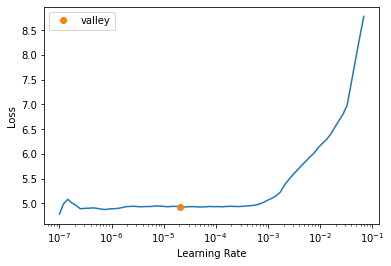

In [4]:
#gpt2 ouput is tuple, we need just one val
class DropOutput(Callback):
  def after_pred(self): self.learn.pred = self.pred[0]
      
      
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), 
cbs=[DropOutput], metrics=Perplexity()).to_fp16()

lr=learn.lr_find()
print(lr)
learn.fit_one_cycle(50, lr)

In [7]:
prompt=" 경제에 관한 "
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(inp,
                           max_length=128,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           repetition_penalty=2.0,       
                           use_cache=True
                          ) 
tokenizer.decode(preds[0].cpu().numpy())

'경제에 관한  지식에 대한 부재를 느끼고 난 후 다양한 저자의 책을 찾아보고 싶었다.이 책 또한 그런 점에서 굉장히 유익한 책이였다.전작에서 부동산 경매를 통해 큰 수익을 낸 저자가 이번에는 코로나 팬데믹 상황에서 경제 상황을 예측하고 대응했다. 그리고 이를 기반으로 2022년 이후의 세계 경제가 어떻게 움직일지에 대해 전망을 제시한다. 나도 이 책의 목차를 보고 돈의 이동이 있을 거라고 생각한 건 데 그 이유 중 하나는았던 정부의 세금 정책이었다. 하지만 근 40년간 정부가 집값을 잡고 부동산을 안정시키기 위해 엄청난 노력을 기울였기에 지금의 상황에서는 정부 정책을 잘 실행해서 인한 긍정적인 효과가 더 클 수도 있다고 생각한다.'

In [ ]:
learn.model.save_pretrained("./models/kogpt2report_backup_50")